In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

from src.data_processing.processors.TrainingProcessor import TrainingProcessor
from src.utilities.pandas_helpers import filter_columns_by_search, flatten_dataframe

In [17]:
%load_ext autoreload 
%autoreload 2 

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## load preprocessed data

In [58]:
data = pd.read_parquet("/Users/mds8301/iterm_data_storage/full_dataset.parquet.gzip")

pandas.core.frame.DataFrame

## agg data down to max and min for each day

In [97]:
def group_data(df):
    events = filter_columns_by_search(df, 'event')
    actions = filter_columns_by_search(df, 'action')
    mouse = filter_columns_by_search(df, 'mouse')
    sensors = filter_columns_by_search(df, 'sensor')

    return (
        df
        .assign(events = lambda df_: df_[events].idxmax(axis=1).str.replace('event_', ''), 
                  actions = lambda df_: df_[actions].idxmax(axis=1).str.replace('action_', ''),
                    mouse = lambda df_: df_[mouse].idxmax(axis=1).str.replace('mouse_id_', ''), 
                    sensors = lambda df_: df_[sensors].idxmax(axis=1).str.replace('sensor_', '')
                    )

        .drop(columns=events + actions + mouse + sensors)
        .groupby(by = ['events', 'actions', 'sensors', 'mouse', 'day', 'trial_count'], as_index = False).agg({"signal": ["max", "min"]})
        .sort_values(by = ['mouse', 'day', 'trial_count'])
        .pipe(flatten_dataframe)
        .rename(columns = lambda c: c.strip('_'))
        .reset_index(drop=True)
        .drop(columns=['index'])
        # .assign(delta_signal = lambda df_: df_.signal_max - df_.signal_min,
        #         min_norm = )
    )
grouped_data = group_data(data)

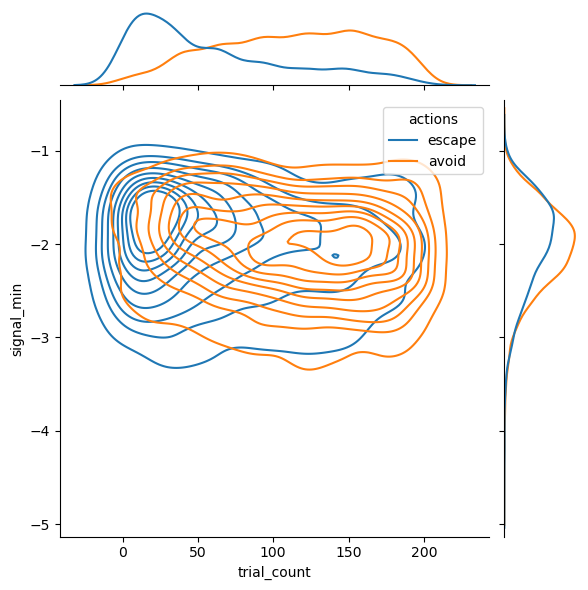

In [87]:
dopamine = grouped_data.query("sensors == 'DA'")
sns.jointplot(
    data=dopamine,
    x="trial_count", y="signal_min", hue="actions",
    kind="kde"
)

In [99]:
events = filter_columns_by_search(grouped_data, 'event')
actions = filter_columns_by_search(grouped_data, 'action')
mouse = filter_columns_by_search(grouped_data, 'mouse')
sensors = filter_columns_by_search(grouped_data, 'sensor')
dummies = pd.get_dummies(data = grouped_data, 
                         columns = events + actions + mouse + sensors)
dummies

,day,trial_count,signal_max,signal_min,events_avoid,events_cue,events_escape,events_shock,actions_avoid,actions_escape,...,mouse_3,mouse_4,mouse_5,mouse_6,mouse_7,mouse_8,mouse_9,sensors_D1,sensors_D2,sensors_DA
0,1,0,2.974904,-1.432352,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,0,2.708953,-2.400061,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,3.046800,-1.360456,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,1,0,2.767575,-2.341439,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1,0,2.971327,-2.349568,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12790,7,171,2.191573,-0.904130,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
12791,7,171,2.967144,-1.169232,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
12792,7,172,1.060174,-2.351187,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
12793,7,172,2.056572,-1.594182,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [112]:
def calculate_max_min_signal(df):
    
    events = filter_columns_by_search(data, 'event')
    actions = filter_columns_by_search(data, 'action')
    mouse = filter_columns_by_search(data, 'mouse')
    sensors = filter_columns_by_search(data, 'sensor')
    return (
        df
        .groupby(by = mouse+events+actions+sensors+['day', 'trial_count'], as_index = False).agg({"signal": ["max", "min"]})
        .pipe(flatten_dataframe)
        .rename(columns = lambda c: c.strip("_"))
        .drop(columns ='index')
    )

max_min = calculate_max_min_signal(data)

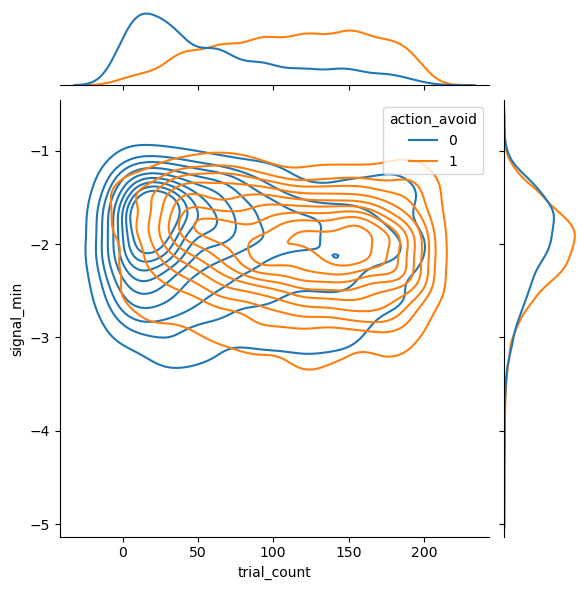

In [113]:
da = max_min.query("sensor_DA == 1")
sns.jointplot(
    data=da,
    x="trial_count", y="signal_min", hue="action_avoid",
    kind="kde"
)

In [136]:
classifer_processor = (TrainingProcessor(max_min[::10])
                       .drop_colinear_columns('action_escape')
                       .query_sensor_and_sort_trials_by_subject(sensor = 'DA')
                       .split_train_val_test_by_subject(target = 'action_avoid')
                       .save_subjects_by_category(path = "/Users/mds8301/iterm_data_storage")
)
classifer_processor.train_x

,mouse_id_0,mouse_id_1,mouse_id_2,mouse_id_3,mouse_id_4,mouse_id_5,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,...,mouse_id_12,mouse_id_13,event_cue,event_escape,event_avoid,event_shock,day,trial_count,signal_max,signal_min
191,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,5,4.786582,-2.522732
211,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,8,5.182160,-2.137000
223,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,10,2.613905,-1.908889
208,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,12,3.394060,-1.677393
192,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,16,3.252482,-1.548552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,7,175,6.051193,-2.203946
392,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,7,183,5.120063,-2.358464
370,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,7,185,4.427547,-1.813413
402,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,7,189,6.029589,-1.634067


In [141]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(classifer_processor.train_x, classifer_processor.train_y, epochs=50, batch_size=32, validation_data=(classifer_processor.val_x, classifer_processor.val_y))

Epoch 1/50
13/13 [==============================] - 0s 22ms/step - loss: 0.6895 - accuracy: 0.6114 - val_loss: 0.5807 - val_accuracy: 0.6947
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6275 - accuracy: 0.6906 - val_loss: 0.5927 - val_accuracy: 0.7053
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6066 - accuracy: 0.7030 - val_loss: 0.5649 - val_accuracy: 0.7263
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.5656 - accuracy: 0.7030 - val_loss: 0.5746 - val_accuracy: 0.7263
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 0.5543 - accuracy: 0.7153 - val_loss: 0.5862 - val_accuracy: 0.7263
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 0.5593 - accuracy: 0.7500 - val_loss: 0.5752 - val_accuracy: 0.7368
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 0.5490 - accuracy: 0.7401 - val_loss: 0.5618 - val_accuracy: 0.7368
Epoch 8/50
13/13 [=